In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
from src.utils.Dataset_loader import get_data_loaders, get_data_loaders_sample

In [7]:
dataset_paths = {
        'dataset1': '/kaggle/input/dataset/Celeb DF(v2)/Celeb DF(v2)',
        'dataset2': '/kaggle/input/dataset/Faceforensics/Faceforensics++'
    }
data_loaders = get_data_loaders(dataset_paths, batch_size=32)

In [8]:
dataset_paths_sample = { 'dataset3': '/kaggle/input/dataset/real-vs-fake/real-vs-fake'}
data_loaders_sample = get_data_loaders_sample(dataset_paths_sample, batch_size=32)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from src.utils.trigger_generator import TriggerGenerator, embed_trigger
from src.attacks.bd_attacks import poison_data_training, poison_data_testing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, criterion, optimizer, clean_test_loader, num_epochs):
    training_loss = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        training_loss.append(epoch_loss)
        # Evaluate model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in clean_test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        clean_accuracy = (correct / total) * 100
        print(f'epoch : {epoch + 1}/{num_epochs}, loss: {epoch_loss:.5f}, accuracy: {clean_accuracy:.2f}%')
    print('Training Completed')
    plt.plot(training_loss)
    plt.title('Training Loss on Backdoor Attacked Model')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.show()
    
    
def evaluate_model(model, clean_test_loader, poisoned_test_loader):
    #evaluation on clean test data
    model.eval()
    correct = 0
    total = 0
    y_true_clean, y_pred_clean = [], []
    with torch.no_grad():
        for inputs, labels in clean_test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true_clean.extend(labels.cpu().numpy())
            y_pred_clean.extend(predicted.cpu().numpy())
    clean_accuracy = (correct/total)*100
    print(f'Accuracy on clean test data: {clean_accuracy}%')
    cm_clean = confusion_matrix(y_true_clean, y_pred_clean)
    disp_clean = ConfusionMatrixDisplay(confusion_matrix=cm_clean, display_labels=['Fake', 'Real'])
    disp_clean.plot(cmap=plt.cm.Blues)
    plt.title('Confusion matrix on clean test data')
    plt.show()
    fpr_clean, tpr_clean, _ = roc_curve(y_true_clean, y_pred_clean)
    auc_clean = roc_auc_score(y_true_clean, y_pred_clean)
    plt.plot(fpr_clean, tpr_clean, label=f"Clean Data (AUC = {auc_clean:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve on Clean Data")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    #Evaluation on poisoned test data
    y_true_poisoned, y_pred_poisoned = [], []
    with torch.no_grad():
        for inputs, labels in poisoned_test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true_poisoned.extend(labels.cpu().numpy())
            y_pred_poisoned.extend(predicted.cpu().numpy())
    cm_poisoned = confusion_matrix(y_true_poisoned, y_pred_poisoned)
    disp_poisoned = ConfusionMatrixDisplay(confusion_matrix=cm_poisoned, display_labels=['Fake', 'Real'])
    disp_poisoned.plot(cmap=plt.cm.Blues)
    plt.title('Confusion matrix on poisoned test data')
    plt.show()
    fpr_poisoned, tpr_poisoned, _ = roc_curve(y_true_poisoned, y_pred_poisoned)
    auc_poisoned = roc_auc_score(y_true_poisoned, y_pred_poisoned)
    plt.plot(fpr_poisoned, tpr_poisoned, label=f"Poisoned Data (AUC = {auc_poisoned:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve on Poisoned Data")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    # Combined evaluation
    y_true_combined = y_true_clean+y_true_poisoned
    y_pred_combined = y_pred_clean+y_pred_poisoned
    cm = confusion_matrix(y_true_combined, y_pred_combined)
    disp_combined = ConfusionMatrixDisplay(cm, display_labels=['Fake', 'Real'])
    disp_combined.plot(cmap=plt.cm.Blues)
    plt.title('Confusion matrix on combined test data')
    plt.show()
    fpr_combined, tpr_combined, _ = roc_curve(y_true_combined, y_pred_combined)
    auc_combined = roc_auc_score(y_true_combined, y_pred_combined)
    plt.plot(fpr_combined, tpr_combined, label=f"Combined Data (AUC = {auc_combined:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve on Combined Data")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    return clean_accuracy

# Backdoor attacks

In [11]:
import torch.nn.functional as F
trigger_generator = TriggerGenerator()
trigger_generator.load_state_dict(torch.load('/kaggle/input/erthkgf/pytorch/default/1/generator.pth', weights_only=True))
trigger_generator = trigger_generator.to(device)
trigger_generator.eval()

TriggerGenerator(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Poisoning training data and seperating clean & poisoned sets

In [12]:
train_loader1 = poison_data_training(data_loaders['dataset1']['train'], trigger_generator, training=True, poison_ratio=0.2)

In [13]:
poisoned_test_loader1, clean_test_loader1= poison_data_testing(data_loaders['dataset1']['test'], trigger_generator, poison_ratio=0.1)

In [14]:
train_loader2 = poison_data_training(data_loaders['dataset2']['train'], trigger_generator, training=True, poison_ratio=0.2)

In [15]:
poisoned_test_loader2, clean_test_loader2= poison_data_testing(data_loaders['dataset2']['test'], trigger_generator, poison_ratio=0.1)

In [16]:
train_loader3 = poison_data_training(data_loaders_sample['dataset3']['train'], trigger_generator, training=True, poison_ratio=0.2)

In [17]:
poisoned_test_loader3, clean_test_loader3= poison_data_testing(data_loaders_sample['dataset3']['test'], trigger_generator, poison_ratio=0.1)

# Merging the datasets to build a generalized model

In [20]:
from torch.utils.data import DataLoader, ConcatDataset
combined_train = ConcatDataset([train_loader1.dataset, train_loader2.dataset, train_loader3.dataset])
combined_clean_test = ConcatDataset([clean_test_loader1.dataset, clean_test_loader2.dataset, clean_test_loader3.dataset])
combined_poison_test = ConcatDataset([poisoned_test_loader1.dataset, poisoned_test_loader2.dataset, poisoned_test_loader3.dataset])
train_loader = DataLoader(combined_train, batch_size=32, shuffle=True)
clean_test_loader = DataLoader(combined_clean_test, batch_size=32, shuffle=False)
poison_test_loader = DataLoader(combined_poison_test, batch_size=32, shuffle=False)

epoch : 1/10, loss: 0.38063, accuracy: 84.79%
epoch : 2/10, loss: 0.25781, accuracy: 85.46%
epoch : 3/10, loss: 0.20052, accuracy: 85.64%
epoch : 4/10, loss: 0.16413, accuracy: 84.17%
epoch : 5/10, loss: 0.13250, accuracy: 85.23%
epoch : 6/10, loss: 0.10753, accuracy: 84.61%
epoch : 7/10, loss: 0.09097, accuracy: 84.89%
epoch : 8/10, loss: 0.07984, accuracy: 84.56%
epoch : 9/10, loss: 0.07140, accuracy: 83.69%
epoch : 10/10, loss: 0.06013, accuracy: 84.33%
Training Completed


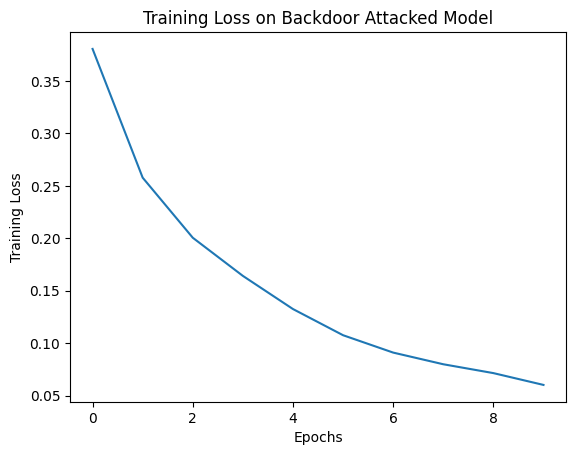

In [21]:
from src.utils.Model import MobileNetV3Model
import torch.optim as optim
model = MobileNetV3Model(num_classes=2).to(device)
for param in model.parameters():
    param.requires_grad = False 
for param in model.pretrained_model.classifier.parameters():
    param.requires_grad = True
for param in model.final_fc.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
train_model(model, train_loader, criterion, optimizer, clean_test_loader, num_epochs=10)

Accuracy on clean test data: 84.33104350670591%


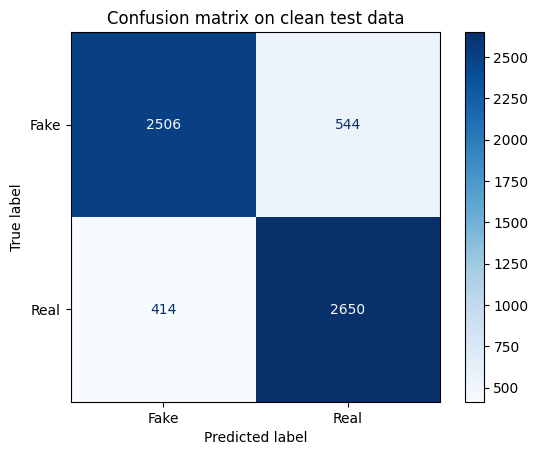

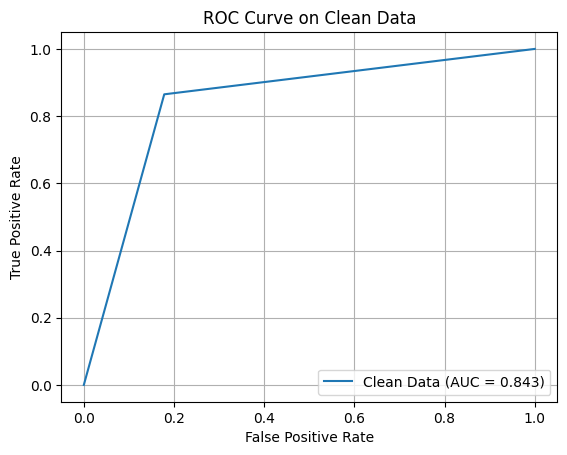

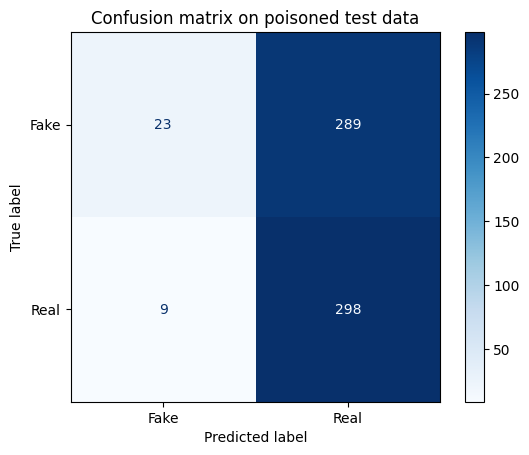

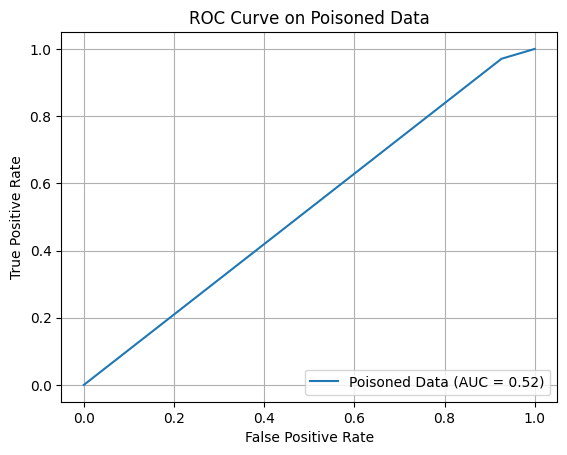

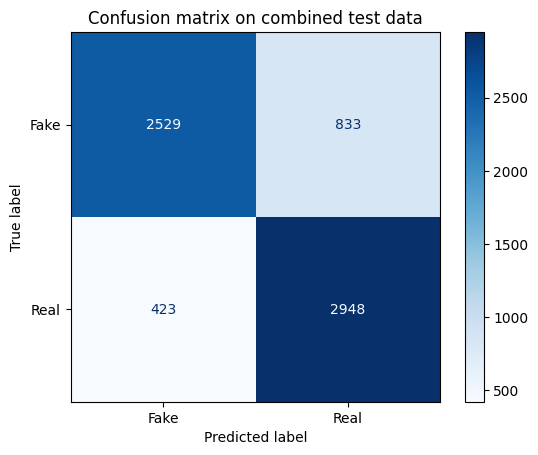

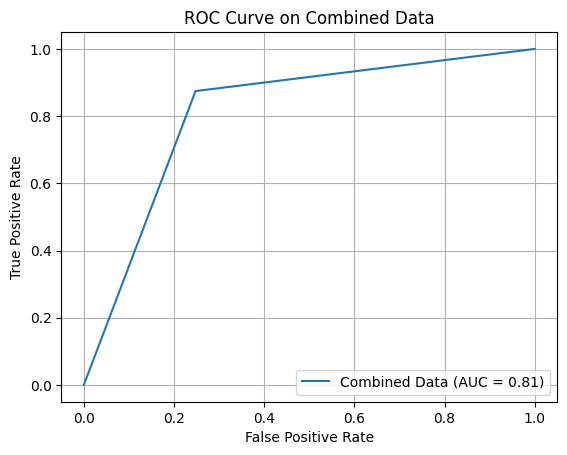

In [47]:
clean_accuracy = evaluate_model(model, clean_test_loader, poison_test_loader)

In [49]:
torch.save(model.state_dict(), 'combined_model.pth')

# Backdoor detection

Clean Means - Mean: -2.7777, Std: 1.4288
Poison Means - Mean: -2.0595, Std: 1.4883


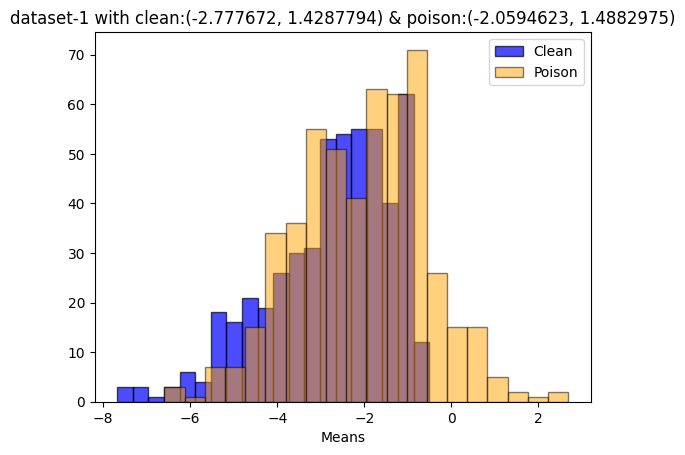

In [26]:
from src.defender.bd_detection import register, collect_activations, compute_distributions

def plot_distributions(clean_distributions, poison_distributions, layer_name):
    clean_means = clean_distributions[layer_name][0]
    poison_means = poison_distributions[layer_name][0]
    clean_mean_val = clean_means.mean()
    clean_std_val = clean_means.std()
    poison_mean_val = poison_means.mean()
    poison_std_val = poison_means.std()
    print(f"Clean Means - Mean: {clean_mean_val:.4f}, Std: {clean_std_val:.4f}")
    print(f"Poison Means - Mean: {poison_mean_val:.4f}, Std: {poison_std_val:.4f}")
    plt.hist(clean_means, bins=20, alpha=0.7, label='Clean', color='blue', edgecolor='black')
    plt.hist(poison_means, bins=20, alpha=0.5, label='Poison', color='orange', edgecolor='black')
    plt.title(f'dataset-1 with clean:{clean_mean_val, clean_std_val} & poison:{poison_mean_val, poison_std_val}')
    plt.xlabel('Means')
    plt.legend()
    plt.show()

activations_storage = {'clean':{}, 'test':{}, 'poison':{}}
register(model, mode='clean')
collect_activations(model, clean_test_loader1, mode='clean')
register(model, mode='poison')
collect_activations(model, poisoned_test_loader1, mode='poison')
clean_distributions = compute_distributions(activations_storage['clean'])
poison_distributions = compute_distributions(activations_storage['poison'])
plot_distributions(clean_distributions, poison_distributions, 'last_layer')

In [43]:
from src.defender.bd_detection import compute_nas_scores, compute_threshold, detect_backdoor
register(model, mode='clean')
collect_activations(model, clean_test_loader, mode='clean')
# Compute clean activation distributions
clean_distributions = compute_distributions(activations_storage['clean'])
nas_scores = compute_nas_scores(model, clean_test_loader, clean_distributions, mode='clean')
# Compute NAS threshold for a given rejection rate
rejection_rate = 5  # Adjust based on requirement
threshold = compute_threshold(nas_scores, rejection_rate)
print(f"Threshold computed: {threshold}")
# Detect backdoor samples in the test set
register(model, mode='test')
classifications = detect_backdoor(model, poison_test_loader, clean_distributions, threshold, mode='test')
# Count and report backdoor samples
backdoor_count = classifications.count(1)
print(f'Backdoor detected samples: {(backdoor_count / len(classifications)) * 100:.2f}%')

Threshold computed: 0.9923095703125
Backdoor detected samples: 100.00%
